In [ ]:
# Import the 'drive' module from Google Colab to access Google Drive
from google.colab import drive

# Mount Google Drive to the Colab environment at the specified path
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Copy the dataset ZIP file from Google Drive to the local environment
!cp "/content/drive/My Drive/FYP_Project/CBIS_DDSM.zip" .
# Unzip the dataset quietly (suppress output)
!unzip -qq CBIS_DDSM.zip
# Remove the ZIP file after extraction to save storage space
!rm CBIS_DDSM.zip
# Set the dataset directory path
cbis_path = 'CBIS_DDSM'


In [ ]:
# Install TensorFlow
!pip install tensorflow -qq

In [ ]:
# Import all necessary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

In [ ]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> benign mass
        1 -> malignant mass
        2 -> benign calcification
        3 -> malignant calcification
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [ ]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


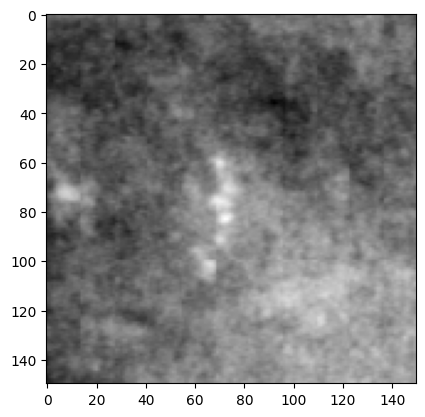

Label: [0. 0. 1. 0.]


In [ ]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

In [ ]:


model_1 = models.Sequential()
model_1.add(Input(shape=(150, 150, 1)))  # Explicit input layer
model_1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(48, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(4, activation='softmax'))

model_1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │       602,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 990,196 (3.78 MB)

 Trainable params: 990,196 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_1_4cl_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 1e-3  # Same decay as in RMSprop
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Use the custom decay in the LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_decay)

# Compile the model
model_1.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Remove any workers/use_multiprocessing from fit() if you passed those
history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=int(0.8 * n_train_img) // 128,
    epochs=500,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, lr_scheduler],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

# Save
models.save_model(model_1, 'model_1_4cl_end.keras')
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.4070 - loss: 1.2522
Epoch 1: val_loss improved from inf to 1.13223, saving model to model_1_4cl_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 504ms/step - accuracy: 0.4058 - loss: 1.2541 - val_accuracy: 0.4692 - val_loss: 1.1322 - learning_rate: 0.0010
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4766 - loss: 1.1649

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.13223
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4766 - loss: 1.1649 - val_accuracy: 0.5346 - val_loss: 1.1336 - learning_rate: 9.9900e-04
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4087 - loss: 1.2207
Epoch 3: val_loss did not improve from 1.13223
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.4092 - loss: 1.2204 - val_accuracy: 0.3869 - val_loss: 1.1825 - learning_rate: 9.9800e-04
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3438 - loss: 1.2828
Epoch 4: val_loss did not improve from 1.13223
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3438 - loss: 1.2828 - val_accuracy: 0.4748 - val_loss: 1.2432 - learning_rate: 9.9701e-04
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4222 - loss: 1.2330
Epoch 5: val_loss improved from 1.13223 to 1.13051, saving model to model_1_4cl_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.4232 - loss: 1.2322

In [ ]:
# Use correct keys for accuracy in history
tra_loss_1 = history_1.history['loss']
tra_acc_1 = history_1.history['accuracy']
val_loss_1 = history_1.history['val_loss']
val_acc_1 = history_1.history['val_accuracy']

epochs_1 = range(1, len(tra_acc_1) + 1)
end_epoch_1 = len(tra_acc_1)

opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1 - 1]
opt_val_acc_1 = val_acc_1[opt_epoch_1 - 1]

opt_model_1 = models.load_model('model_1_4cl_best.keras')

test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=0)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=0)

# Predict only using test images
opt_pred_1 = opt_model_1.predict(test_images)

# Get predicted class indices
pred_classes_1 = np.argmax(opt_pred_1, axis=1)

# Convert test labels from one-hot to class indices if needed
if test_labels.ndim == 2:
    true_classes = np.argmax(test_labels, axis=1)
else:
    true_classes = test_labels

print("Model 1\n")
print(f"Epoch [end]: {end_epoch_1}")
print(f"Epoch [opt]: {opt_epoch_1}")
print(f"Valid accuracy [end]: {end_val_acc_1:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_1:.4f}")
print(f"Test accuracy [end]:  {test_acc_1:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_1:.4f}")
print(f"Valid loss [end]: {end_val_loss_1:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_1:.4f}")
print(f"Test loss [end]:  {test_loss_1:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_1:.4f}")

print(classification_report(true_classes, pred_classes_1, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Model 1

Epoch [end]: 491
Epoch [opt]: 411
Valid accuracy [end]: 0.6467
Valid accuracy [opt]: 0.6673
Test accuracy [end]:  0.5833
Test accuracy [opt]:  0.5714
Valid loss [end]: 0.8149
Valid loss [opt]: 0.7693
Test loss [end]:  1.0060
Test loss [opt]:  0.9833
              precision    recall  f1-score   support

           0     0.6667    0.4071    0.5055       113
           1     0.4274    0.7576    0.5464        66
           2     0.6783    0.7358    0.7059       106
           3     0.5143    0.3529    0.4186        51

    accuracy                         0.5714       336
   macro avg     0.5716    0.5634    0.5441       336
weighted avg     0.6002    0.5714    0.5636       336



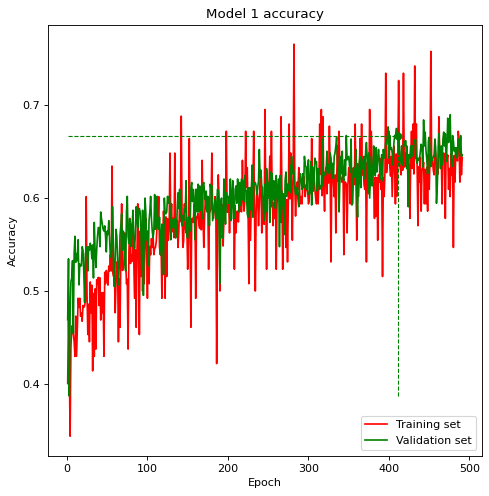

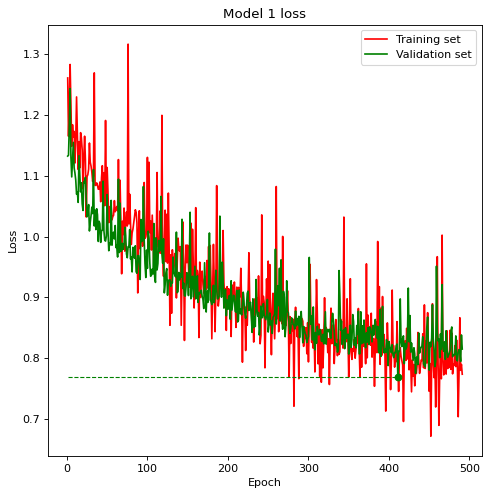

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


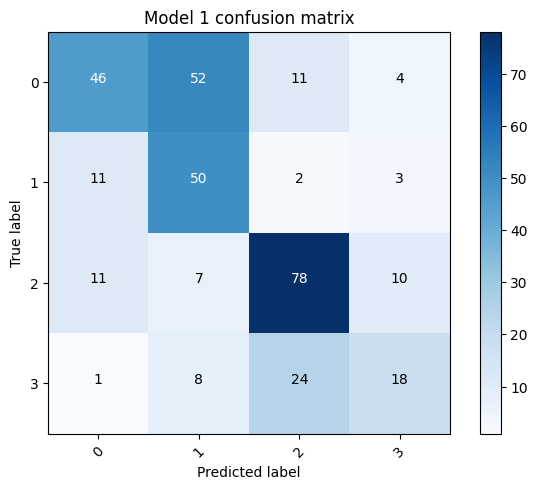

In [ ]:
# Predict class probabilities
pred_1_probs = opt_model_1.predict(test_images)

# Get the class with the highest probability
pred_1_classes = np.argmax(pred_1_probs, axis=1)

# Generate confusion matrix
confusion_mtx = confusion_matrix(test_labels_raw, pred_1_classes)

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 1 confusion matrix')

In [ ]:
model_2 = models.Sequential()
model_2.add(Input(shape=(150, 150, 1)))  # Explicit input layer
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(4, activation='softmax'))

model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,104,964 (19.47 MB)

 Trainable params: 5,104,964 (19.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

checkpoint = ModelCheckpoint('model_2_4cl_best.keras',
                             monitor='val_loss', mode='min', verbose=1,
                             save_best_only=True, save_freq='epoch')
# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 5e-4
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)

model_2.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=int(0.8 * n_train_img) // 128,
    epochs=500,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, lr_scheduler],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

models.save_model(model_2, 'model_2_4cl_end.keras')

# Copy files to Google Drive (make sure drive is mounted and path is correct)
!cp model* "/content/drive/My Drive/FYP_Project/models/"


Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.3002 - loss: 2.0083
Epoch 1: val_loss improved from inf to 1.37248, saving model to model_2_4cl_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 897ms/step - accuracy: 0.3017 - loss: 1.9872 - val_accuracy: 0.3589 - val_loss: 1.3725 - learning_rate: 0.0010
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3672 - loss: 1.3734

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.37248 to 1.36704, saving model to model_2_4cl_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3672 - loss: 1.3734 - val_accuracy: 0.3589 - val_loss: 1.3670 - learning_rate: 9.9950e-04
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.3542 - loss: 1.3752
Epoch 3: val_loss improved from 1.36704 to 1.35577, saving model to model_2_4cl_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.3541 - loss: 1.3751 - val_accuracy: 0.3589 - val_loss: 1.3558 - learning_rate: 9.9900e-04
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3516 - loss: 1.3613
Epoch 4: val_loss did not improve from 1.35577
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3516 - loss: 1.3613 - val_accuracy: 0.3589 - val_loss: 1.3575 - learning_rate: 9.9850e-04
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3559 - loss: 1.3634
Epoch 5: val_loss did not improve from 1.35577
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [ ]:
# History of accuracy and loss
tra_loss_2 = history_2.history['loss']
tra_acc_2 = history_2.history['accuracy']          # <-- fix key here
val_loss_2 = history_2.history['val_loss']
val_acc_2 = history_2.history['val_accuracy']      # <-- fix key here

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2) + 1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2 - 1]
opt_val_acc_2 = val_acc_2[opt_epoch_2 - 1]

# Load best model and evaluate on test set
opt_model_2 = models.load_model('model_2_4cl_best.keras')
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)
opt_pred_2 = opt_model_2.predict(test_images)
pred_classes_2 = np.argmax(opt_pred_2, axis=1)

print("Model 2\n")
print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f" % opt_test_loss_2)

print(classification_report(true_classes, pred_classes_2, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Model 2

Epoch [end]: 500
Epoch [opt]: 489
Valid accuracy [end]: 0.6411
Valid accuracy [opt]: 0.6579
Test accuracy [end]:  0.5357
Test accuracy [opt]:  0.5952
Valid loss [end]: 0.8724
Valid loss [opt]: 0.8305
Test loss [end]:  0.9952
Test loss [opt]:  0.9463
              precision    recall  f1-score   support

           0     0.7065    0.5752    0.6341       113
           1     0.4524    0.5758    0.5067        66
           2     0.7212    0.7075    0.7143       106
           3     0.3929    0.4314    0.4112        51

    accuracy                         0.5952       336
   macro avg     0.5682    0.5725    0.5666       336
weighted avg     0.6136    0.5952    0.6005       336



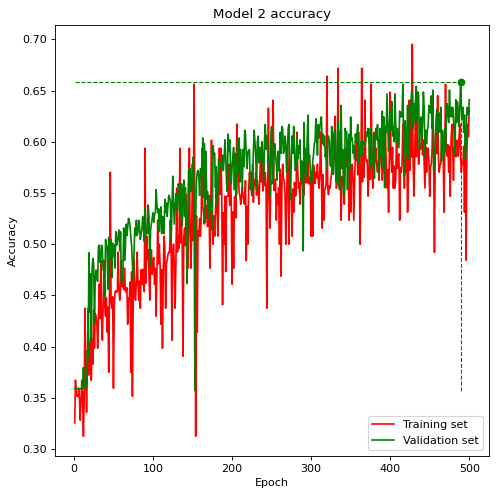

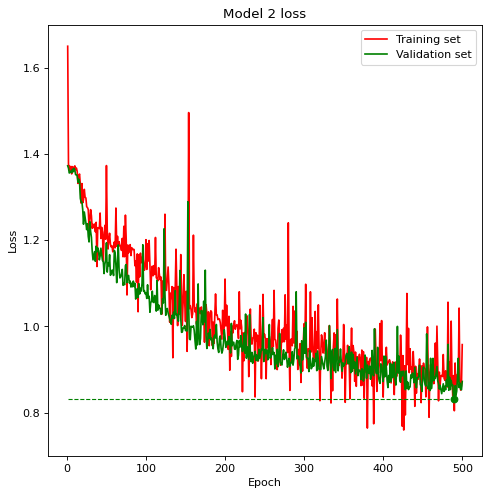

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.7, 1.7)
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


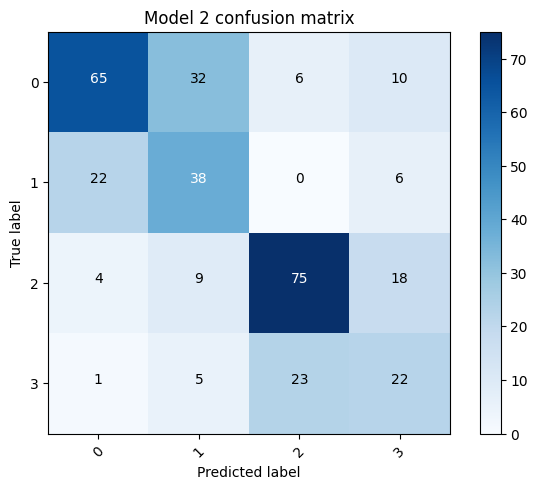

In [ ]:
# Predict class probabilities
pred_2_probs = opt_model_2.predict(test_images)

# Get the class with the highest probability
pred_2_classes = np.argmax(pred_2_probs, axis=1)

# Generate confusion matrix
confusion_mtx = confusion_matrix(test_labels_raw, pred_2_classes)

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 2 confusion matrix')

In [ ]:
model_3 = models.Sequential()
model_3.add(Input(shape=(150, 150, 1)))  # Explicit input layer
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(4, activation='softmax'))

model_3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,155,780 (12.04 MB)

 Trainable params: 3,155,780 (12.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

checkpoint = ModelCheckpoint('model_3_4cl_best.keras',
                             monitor='val_loss', mode='min', verbose=1,
                             save_best_only=True, save_freq='epoch')
# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 5e-4
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)

model_3.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_3 = model_3.fit(
    train_generator,
    steps_per_epoch=int(0.8 * n_train_img) // 128,
    epochs=500,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, lr_scheduler],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

models.save_model(model_3, 'model_3_4cl_end.keras')

!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.2984 - loss: 1.6999
Epoch 1: val_loss improved from inf to 1.36168, saving model to model_3_4cl_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accuracy: 0.3002 - loss: 1.6887 - val_accuracy: 0.3589 - val_loss: 1.3617 - learning_rate: 0.0010
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.2688 - loss: 1.4033

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.36168
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2688 - loss: 1.4033 - val_accuracy: 0.3589 - val_loss: 1.3738 - learning_rate: 9.9950e-04
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3483 - loss: 1.3705
Epoch 3: val_loss improved from 1.36168 to 1.35617, saving model to model_3_4cl_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.3482 - loss: 1.3704 - val_accuracy: 0.3589 - val_loss: 1.3562 - learning_rate: 9.9900e-04
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4453 - loss: 1.3293
Epoch 4: val_loss improved from 1.35617 to 1.35309, saving model to model_3_4cl_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4453 - loss: 1.3293 - val_accuracy: 0.3589 - val_loss: 1.3531 - learning_rate: 9.9850e-04
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3668 - loss: 1.3595
Epoch 5: val_loss did not improve from 1.35309
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [ ]:
# History of accuracy and loss
tra_loss_3 = history_3.history['loss']
tra_acc_3 = history_3.history['accuracy']         # Fix here
val_loss_3 = history_3.history['val_loss']
val_acc_3 = history_3.history['val_accuracy']     # Fix here

# Total number of epochs training
epochs_3 = range(1, len(tra_acc_3) + 1)
end_epoch_3 = len(tra_acc_3)

# Epoch when reached the validation loss minimum
opt_epoch_3 = val_loss_3.index(min(val_loss_3)) + 1

# Loss and accuracy on the validation set
end_val_loss_3 = val_loss_3[-1]
end_val_acc_3 = val_acc_3[-1]
opt_val_loss_3 = val_loss_3[opt_epoch_3 - 1]
opt_val_acc_3 = val_acc_3[opt_epoch_3 - 1]

# Load best model and evaluate on test set
opt_model_3 = models.load_model('model_3_4cl_best.keras')
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_3, opt_test_acc_3 = opt_model_3.evaluate(test_images, test_labels, verbose=False)

# Predict classes - only pass inputs, not labels
opt_pred_3 = opt_model_3.predict(test_images)
pred_classes_3 = np.rint(opt_pred_3)  # Round softmax probabilities to nearest integer (0 or 1)

print("Model 3\n")
print("Epoch [end]: %d" % end_epoch_3)
print("Epoch [opt]: %d" % opt_epoch_3)
print("Valid accuracy [end]: %.4f" % end_val_acc_3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_3)
print("Test accuracy [end]:  %.4f" % test_acc_3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_3)
print("Valid loss [end]: %.4f" % end_val_loss_3)
print("Valid loss [opt]: %.4f" % opt_val_loss_3)
print("Test loss [end]:  %.4f" % test_loss_3)
print("Test loss [opt]:  %.4f" % opt_test_loss_3)

print(classification_report(test_labels, pred_classes_3, digits=4, zero_division=0))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Model 3

Epoch [end]: 464
Epoch [opt]: 384
Valid accuracy [end]: 0.6243
Valid accuracy [opt]: 0.6486
Test accuracy [end]:  0.6101
Test accuracy [opt]:  0.5952
Valid loss [end]: 0.8445
Valid loss [opt]: 0.7707
Test loss [end]:  0.9899
Test loss [opt]:  0.9479
              precision    recall  f1-score   support

           0     0.6835    0.4779    0.5625       113
           1     0.4681    0.3333    0.3894        66
           2     0.7174    0.6226    0.6667       106
           3     0.6111    0.2157    0.3188        51

   micro avg     0.6483    0.4554    0.5350       336
   macro avg     0.6200    0.4124    0.4843       336
weighted avg     0.6409    0.4554    0.5244       336
 samples avg     0.4554    0.4554    0.4554       336



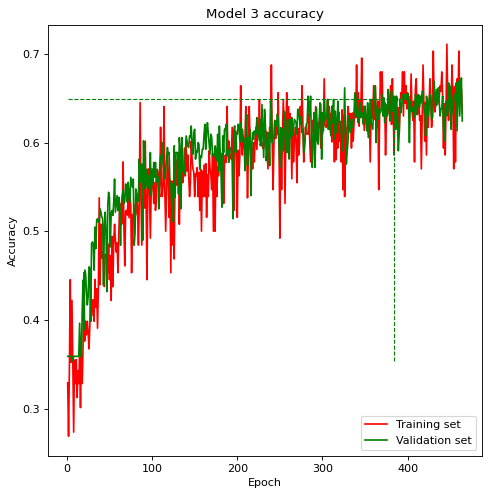

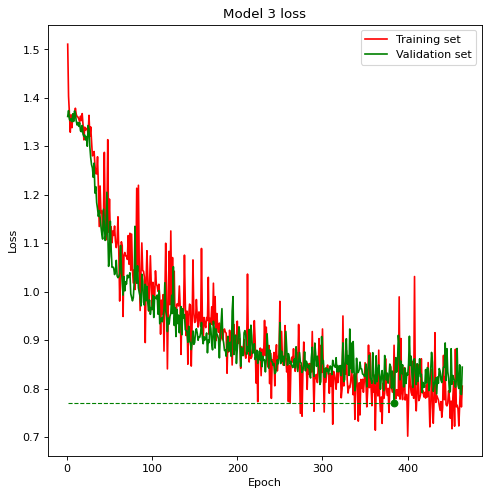

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_acc_3, 'r', label='Training set')
plt.plot(epochs_3, val_acc_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_acc_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_acc_3), opt_val_acc_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_loss_3, 'r', label='Training set')
plt.plot(epochs_3, val_loss_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_loss_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_loss_3), opt_val_loss_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend();

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


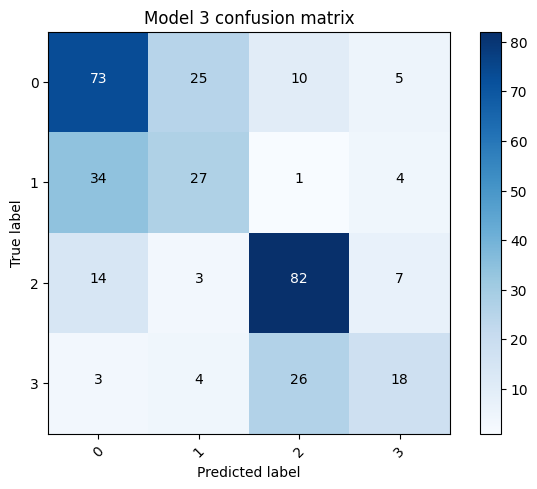

In [ ]:
# Predict class probabilities
pred_3_probs = opt_model_3.predict(test_images)

# Get the class with the highest probability
pred_3_classes = np.argmax(pred_3_probs, axis=1)

# Generate confusion matrix
confusion_mtx = confusion_matrix(test_labels_raw, pred_3_classes)

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 3 confusion matrix')